# INSTALL LIBRARY

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install underthesea
!pip install transformers
!pip install vncorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 49.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vn

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.2.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


--2023-06-27 10:06:40--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.2.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412703 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.2.jar’

VnCoreNLP-1.2.jar   100%[===================>]  26.14M  --.-KB/s    in 0.06s   

2023-06-27 10:06:41 (419 MB/s) - ‘VnCoreNLP-1.2.jar’ saved [27412703/27412703]

--2023-06-27 10:06:41--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

In [ ]:
import pandas as pd
import numpy as np
import re
from underthesea import word_tokenize,pos_tag
# from pyvi import ViTokenizer, ViPosTagger
import seaborn as sns
from matplotlib import pyplot as plt
from keras.utils import to_categorical,pad_sequences
from vncorenlp import VnCoreNLP


In [ ]:
from keras.initializers import Constant
from keras.layers import Dense,Input,GlobalAveragePooling1D ,concatenate,Dropout,GRU,Bidirectional,TimeDistributed, Embedding, Attention, LSTM,Convolution1D,MaxPooling1D,Flatten,SpatialDropout1D,LeakyReLU,AveragePooling1D,MultiHeadAttention,GlobalMaxPooling1D,Dropout
from keras.models import Model
from keras.optimizers import Adamax,Adam
from keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from keras.regularizers import L1,L2
# from tensorflow_addons.layers import CRF
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from keras.initializers import Orthogonal
from keras.callbacks import EarlyStopping

In [ ]:
from sklearn.metrics import classification_report,f1_score,precision_score,recall_score,classification_report


In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 13.4 MB/s eta 0:00:00


In [ ]:
PRETRAINED_MODEL = "vinai/phobert-base"
SEP = "</s>"
MAX_LEN = 256
BATCH_SIZE = 8

# LOAD DATA

## PREPROCESSING

In [ ]:
class TextNormalize:
    def __init__(self):
        self.vowels_to_ids = {}
        self.vowels_table = [
            ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
            ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
            ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
            ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
            ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
            ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
            ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
            ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'o'],
            ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
            ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
            ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
            ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
        ]
        pass

    def createVowelsTable(self):
        """Create Vowels Table"""
        for i in range(len(self.vowels_table)):
            for j in range(len(self.vowels_table[i]) - 1):
                self.vowels_to_ids[self.vowels_table[i][j]] = (i, j)

    def IsValidVietnameseWord(self,word):
        """Nguyên âm chỉ có thể đứng chung với nguyên âm. Một từ không thể có 2 nguyên âm cách nhau bởi 1 phụ âm"""
        chars = list(word)
        #nguyen am
        vowel_index = -1
        for i in range(len(chars)):
            idx_vowel_table = self.vowels_to_ids.get(chars[i],(-1,-1))[0]
            if idx_vowel_table != -1:
                if vowel_index == -1:
                    vowel_index = i
                else:
                    if i - vowel_index != 1:
                        return False
                    vowel_index = i
        return True

    def WordStandardized(self,word):
        """Standardize Word"""
        if not self.IsValidVietnameseWord(word):
            return word

        chars = list(word)
        vowel_indexes = []

        # tìm vị trí nguyên âm
        qu_or_gi = False
        thanh_dieu = 0
        for i in range(len(chars)):
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[i],(-1,-1))
            if vowel_table_row == -1 :
                continue
            # qu
            if vowel_table_row == 9:
                if i != 0 and chars[i-1] == 'q':
                    chars[i] = 'u'
                    qu_or_gi = True
            # gi
            elif vowel_table_row == 5:
                if i != 0 and chars[i-1] == 'g':
                    chars[i] = 'i'
                    qu_or_gi = True

            # có chứa thanh điệu
            if vowel_table_col != 0:
                thanh_dieu = vowel_table_col
                chars[i] = self.vowels_table[vowel_table_row][0]

            vowel_indexes.append(i)
        # 1 nguyên âm
        if len(vowel_indexes) == 1:
            c = chars[vowel_indexes[0]]
            chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
            return ''.join(chars)

        for idx_vowel in vowel_indexes:
            vowel_table_row, vowel_table_col = self.vowels_to_ids.get(chars[idx_vowel],(-1,-1))
            #ê, ơ, ô
            if vowel_table_row == 4 or vowel_table_row == 7 or vowel_table_row == 8:
                c = chars[idx_vowel]
                chars[idx_vowel] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # kiểm tra qu và gi, 2-3 nguyên âm thì nguyên âm thứ 2 chứa dấu
            if qu_or_gi:
                if len(vowel_indexes) == 2 or len(vowel_indexes) == 3:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            # 2 nguyên âm
            if len(vowel_indexes) == 2:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[0]]
                    chars[vowel_indexes[0]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

            elif len(vowel_indexes) == 3:
                # âm cuối là nguyên âm
                if vowel_indexes[-1] == len(chars) - 1:
                    c = chars[vowel_indexes[1]]
                    chars[vowel_indexes[1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                else:
                    c = chars[vowel_indexes[-1]]
                    chars[vowel_indexes[-1]] = self.vowels_table[self.vowels_to_ids[c][0]][thanh_dieu]
                return ''.join(chars)

        return ''.join(chars)

    def normalize(self,text):

        #Chuyen sang viet thuong
        text = text.lower()

        # Rút gọn từ kéo dài
        text = re.sub(r'(\w)\1+',r'\1',text)

        # xóa các emoji dư thừa
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'',text) # no emoji

        text = text.split()
        # chuẩn hóa thanh điệu
        for i in range(len(text)):
            text[i] = self.WordStandardized(text[i])

        text = ' '.join(text)

        # xóa space d
        text = re.sub(r"( )\1+",r'\1',text)
        text = re.sub(r"[:)^@!`~%;?(\+\-\'\"]+",r'',text)

        # remove hastag
        text = re.sub("(@[A-Za-z0-9]+)|(#[0-9A-Za-z]+)"," ", text)
        return text

In [ ]:
def convert_unicode(text):
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
  char1252 = char1252.split('|')
  charutf8 = charutf8.split('|')

  dic = {}
  for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
  return re.sub(
      r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
      lambda x: dic[x.group()], text
)


In [ ]:
class LoadData():
    def __init__(self, file_path):
        self.file_path = file_path

        self.data = pd.read_json(file_path, lines = True)
        # self.data = self.data.dropna()
        self.X = []
        self.y = []
    def transform(self,x,label):
        y = []
        if len(label) == 0:
          return x,np.array(["O" for i in range(len(x.split()))])

        first_index = label[:,0].astype(int)
        second_index = label[:,1].astype(int)
        asp_cate_pola = label[:,2]
        s = 0
        a = ""
        # chay tu s -> first, cap nhat s
        for i in range(len(label)):

            front = x[s:first_index[i]]
            # print(first_index[i],second_index[i])
            middle = x[first_index[i]:second_index[i]]
            # print(x)
            # print(middle)
            s = second_index[i]

            a += front + " " + middle + " "
            y.extend(["O" for i in range(len(front.split()))])
            y.extend([f"B-{asp_cate_pola[i]}" if j == 0 else f"I-{asp_cate_pola[i]}" for j in range(len(middle.split()))])

        if s != len(x):
            a+= x[s:]
            y.extend(["O" for i in range(len(x[s:].split()))])

        # print(a)
        # for k, v in zip(a.split(),y):
        #     print(k,"=>",v)
        return a,np.array(y)

    def ExtractAspectTermPosition(self,span_labels):
        labels = []
        # print(aspectTerms)
        for ls in span_labels:
            start = ls[0]
            end = ls[1]
            asp_cate_pola = ls[2]

            labels.append([int(start),int(end), asp_cate_pola])
        return np.array(sorted(labels,key = lambda x: x[0]))

    def load(self,):
        _len = len(self.data)
        for i in range(_len):
            x = self.data.iloc[i,1].strip() #text
            if len(x.split(" ")) > 273:
              continue
            span_labels = self.data.iloc[i,2] #label
            span_labels = np.array(sorted(span_labels,key = lambda x: x[0]))

            x,y = self.transform(x,span_labels)
            self.X.append(convert_unicode(x))
            self.y.append(y)

        return self.X,self.y

## READ DATA

In [ ]:
X_train,y_train = LoadData("/content/drive/MyDrive/deep/data/train_data.txt").load()
X_val, y_val = LoadData("/content/drive/MyDrive/deep/data/val_data.txt").load()
X_test, y_test = LoadData("/content/drive/MyDrive/deep/data/test_data.txt").load()

<Axes: ylabel='Count'>

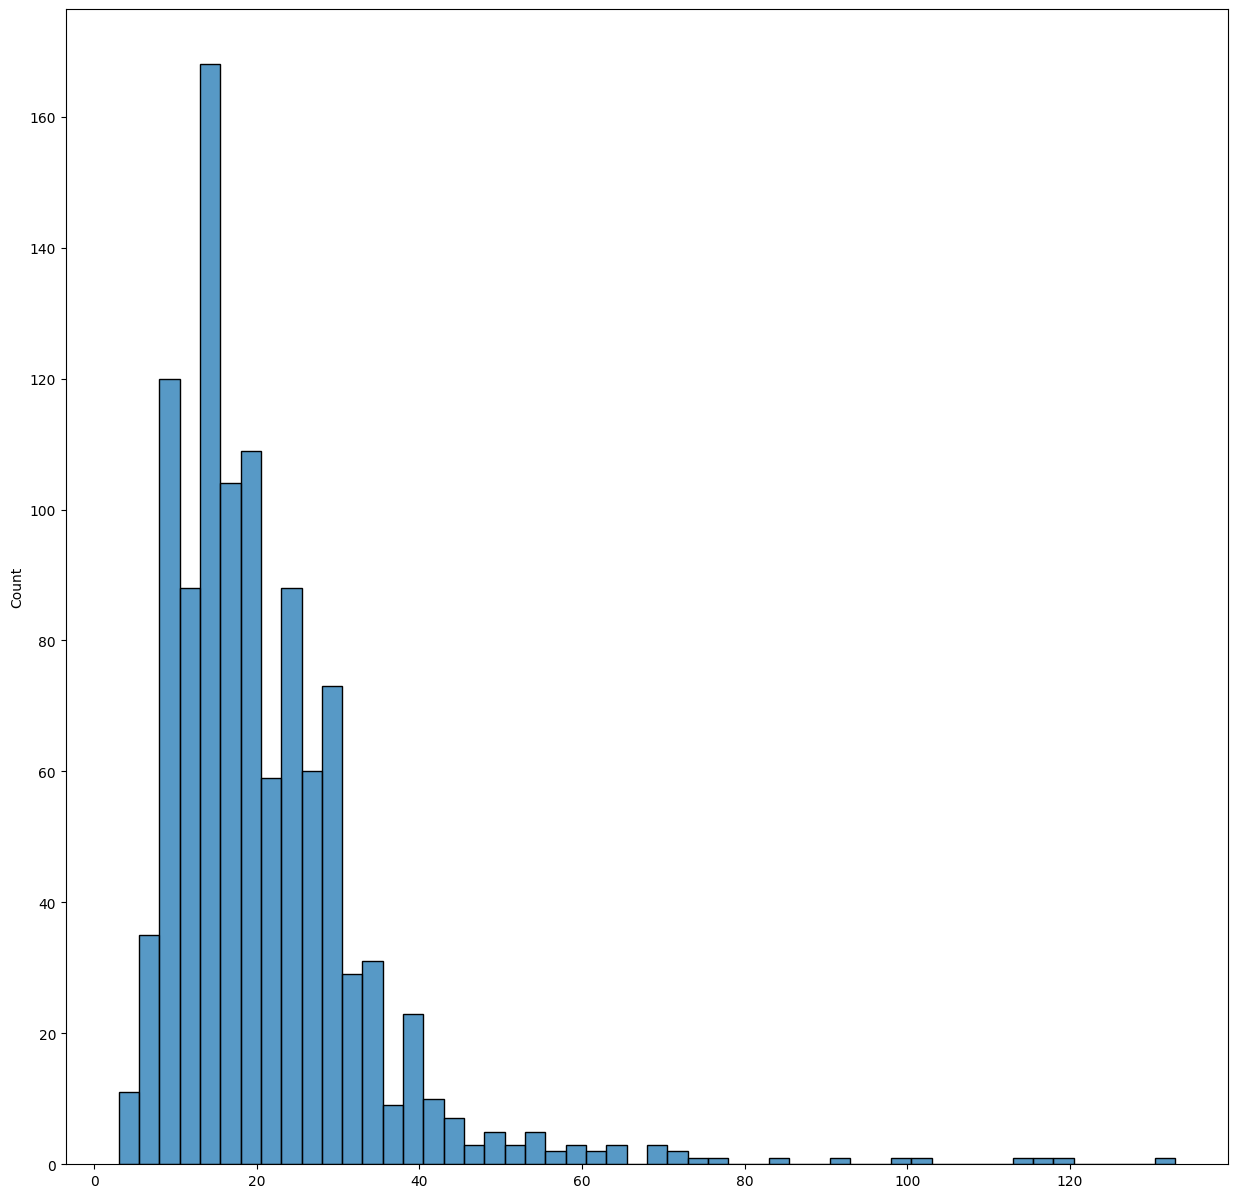

In [ ]:
temp = []
for k in X_train:
    k = k.split()
    temp.append(len(k))
plt.figure(figsize = (15,15))
sns.histplot(temp)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

## Word Segmentation


In [ ]:
class AlignLabel():
  def __init__(self):
    pass
  def Convert2LabelPosition(self,label):
    labels_position = []
    lst_first_pos = np.array([i if "B-" in v else -1 for i,v in enumerate(label)])
    lst_first_pos = np.argwhere(lst_first_pos != -1).reshape(1,-1)[0]
    for i in range(len(lst_first_pos)):
      # if i reach last pos: label range should be (i,len(label))
      last_pos = lst_first_pos[i]
      if i == len(lst_first_pos) - 1:
        for j in range(lst_first_pos[i],len(label)):
          if "I-" in label[j]:
            last_pos = j
      else:
        for j in range(lst_first_pos[i],lst_first_pos[i+1]):
          if "I-" in label[j]:
            last_pos = j
      labels_position.append([lst_first_pos[i],last_pos,label[lst_first_pos[i]]])

    return np.array(labels_position)

  def segment_and_alignLabel(self,x,y,tokenizer, SEP):
    def segment_and_addSEP(seg,ismid):
      seg = tokenizer.tokenize(seg)
      seg = [" ".join(s) for s in seg]
      seg = " ".join(seg)
      return seg


    y_new = []
    label = self.Convert2LabelPosition(y)
    preprocess = TextNormalize()

    if len(label) == 0:
      x_temp = preprocess.normalize(x)
      x_temp = segment_and_addSEP(x_temp,False)
      x_temp = " ".join(x_temp.split())
      y_new = ["O" for i in range(len(x_temp.split()))]
      return  [x_temp,np.array(y_new)]

    first_index = label[:,0].astype(int)
    second_index = label[:,1].astype(int)
    asp_cate_pola = label[:,2]
    s = 0
    a = ""
    x = x.split()
    for i in range(len(label)):
        front = " ".join(x[s:first_index[i]])
        if first_index[i] == second_index[i]:
          middle = x[first_index[i]]
          s = second_index[i] + 1
        else:
          middle = " ".join(x[first_index[i]:second_index[i]+1])
          s = second_index[i]+1

        front = preprocess.normalize(front)
        middle = preprocess.normalize(middle)

        front = segment_and_addSEP(front,False)
        middle = segment_and_addSEP(middle,True )

        a += front + " " + middle + " "
        y_new.extend(["O" for i in range(len(front.split()))])

        if first_index[i] == second_index[i]:
          y_new.extend([f"B-{asp_cate_pola[i][2:]}"])
        else:
          y_new.extend([f"B-{asp_cate_pola[i][2:]}" if j == 0 else f"I-{asp_cate_pola[i][2:]}" for j in range(len(middle.split(" ")))])

    if s != len(x):
        enc = " ".join(x[s:])
        enc = preprocess.normalize(enc)
        enc = segment_and_addSEP(enc,False)
        a+= enc
        y_new.extend(["O" for i in range(len(enc.split()))])

    a = " ".join(a.split())
    return [a,np.array(y_new)]

  def tokenize_and_alignlabel(self,x,y,tag2idx,tokenizer):
    x = x.strip().split(" ")
    y_position = self.Convert2LabelPosition(y)
    if len(y_position) == 0:
      return np.zeros(MAX_LEN)

    first_index = y_position[:,0].astype(int)
    second_index = y_position[:,1].astype(int)
    asp_cate_pola = y_position[:,2]
    y_new = np.zeros(MAX_LEN)
    x_tokenize = []
    s = 0
    pre_len = 0
    y_position = 1
    for i in range(len(first_index)):
      front_len = len(tokenizer(" ".join(x[s:first_index[i]]),add_special_tokens = False)['input_ids'])
      y_new[y_position:y_position + front_len] = tag2idx["O"]
      y_position += front_len

      if first_index[i] == second_index[i]:
        words = tokenizer(x[first_index[i]],add_special_tokens = False)['input_ids']
        s = second_index[i] + 1
        # print(x[first_index[i]])

      else:
        # print(x[first_index[i]:second_index[i]+1],)
        words = tokenizer(" ".join(x[first_index[i]:second_index[i]+1]),add_special_tokens = False)['input_ids']
        s = second_index[i] + 1
      y_new[y_position] = tag2idx[f'B-{asp_cate_pola[i][2:]}']
      # print(words)
      if len(words) >= 2:
        y_new[y_position+1:y_position+1+len(words)-1] = tag2idx[f'I-{asp_cate_pola[i][2:]}'] # skip B-name position, subtract -1 because len(words) contain B-name

      y_position += len(words)

    tokenize_last_sents = tokenizer(" ".join(x[s:]),add_special_tokens = False)['input_ids']
    y_new[y_position:y_position + len(tokenize_last_sents) + 1] = tag2idx["O"]

    end_sep_position = y_position  + len(tokenizer(" ".join(x[s:])))

    y_new[0] = tag2idx['O']
    y_new[end_sep_position ] = tag2idx['O']

    return y_new

  def transform(self,x_raw,y_raw,rdrsegmenter,SEP):
    X = []
    Y = []
    for i in range(len(x_raw)):
      x, y = self.segment_and_alignLabel(x_raw[i],y_raw[i],rdrsegmenter,SEP)
      X.append(x)
      Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X,Y

In [ ]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.2.jar", annotators="wseg", max_heap_size='-Xmx500m')


In [ ]:
align_label = AlignLabel()
X_train, y_train = align_label.transform(X_train,y_train,rdrsegmenter,SEP)
X_val, y_val = align_label.transform(X_val,y_val,rdrsegmenter,SEP)
X_test, y_test = align_label.transform(X_test,y_test,rdrsegmenter,SEP)

<ipython-input-15-5b2f9248f4ed>:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.asarray(Y)


# Embedding

## WORD EMBEDDING

In [ ]:
f= open('/content/drive/MyDrive/deep/word2vec_vi_words_100dims.txt','r',encoding='utf-8')
words = []
embedding_words = {}

i = 0
for line in f:
  if i == 0:
    i+= 1
    continue
  value = line.split(' ')
  word = value[0]
  words.append(word)
  try:
    coefs = value[1:]
    embedding_words[word] = np.asarray(coefs,dtype=np.float32)
  except:
    pass


In [ ]:
embedding_dim = 100

In [ ]:
num_word = len(words)

In [ ]:
word2idx = {w:i for i,w in enumerate(words,start = 2)}
word2idx['PAD'] = 0
word2idx['UNK'] = 1

In [ ]:
idx2word = {i:w for w,i in word2idx.items()}

In [ ]:
with open("/content/drive/MyDrive/deep/data/label.txt",encoding = 'utf-8') as f:
    la = f.readlines()

for i in range(len(la)):
   la[i] = la[i].strip("\n")
la = np.array(la,dtype='object')
la

array(['GENERAL#POSITIVE', 'GENERAL#NEUTRAL', 'GENERAL#NEGATIVE',
       'DISPLAY#POSITIVE', 'DISPLAY#NEUTRAL', 'DISPLAY#NEGATIVE',
       'BATTERY#POSITIVE', 'BATTERY#NEUTRAL', 'BATTERY#NEGATIVE',
       'TOUCHPAD#POSITIVE', 'TOUCHPAD#NEUTRAL', 'TOUCHPAD#NEGATIVE',
       'KEYBOARD#POSITIVE', 'KEYBOARD#NEUTRAL', 'KEYBOARD#NEGATIVE',
       'SERVICE#POSITIVE', 'SERVICE#NEUTRAL', 'SERVICE#NEGATIVE',
       'WARRATY#POSITIVE', 'WARRATY#NEUTRAL', 'WARRATY#NEGATIVE',
       'STORAGE#POSITIVE', 'STORAGE#NEUTRAL', 'STORAGE#NEGATIVE',
       'CONNECTIVITY#POSITIVE', 'CONNECTIVITY#NEUTRAL',
       'CONNECTIVITY#NEGATIVE', 'MULTIMEDIA_DEVICES#POSITIVE',
       'MULTIMEDIA_DEVICES#NEUTRAL', 'MULTIMEDIA_DEVICES#NEGATIVE',
       'DESIGN#POSITIVE', 'DESIGN#NEUTRAL', 'DESIGN#NEGATIVE',
       'FANS_COOLING#POSITIVE', 'FANS_COOLING#NEUTRAL',
       'FANS_COOLING#NEGATIVE', 'PERFORMANCE#POSITIVE',
       'PERFORMANCE#NEUTRAL', 'PERFORMANCE#NEGATIVE', 'PRICE#POSITIVE',
       'PRICE#NEUTRAL', 'PRICE#N

In [ ]:
bi = "B-" + la
ii = "I-" + la

In [ ]:
bi

array(['B-GENERAL#POSITIVE', 'B-GENERAL#NEUTRAL', 'B-GENERAL#NEGATIVE',
       'B-DISPLAY#POSITIVE', 'B-DISPLAY#NEUTRAL', 'B-DISPLAY#NEGATIVE',
       'B-BATTERY#POSITIVE', 'B-BATTERY#NEUTRAL', 'B-BATTERY#NEGATIVE',
       'B-TOUCHPAD#POSITIVE', 'B-TOUCHPAD#NEUTRAL', 'B-TOUCHPAD#NEGATIVE',
       'B-KEYBOARD#POSITIVE', 'B-KEYBOARD#NEUTRAL', 'B-KEYBOARD#NEGATIVE',
       'B-SERVICE#POSITIVE', 'B-SERVICE#NEUTRAL', 'B-SERVICE#NEGATIVE',
       'B-WARRATY#POSITIVE', 'B-WARRATY#NEUTRAL', 'B-WARRATY#NEGATIVE',
       'B-STORAGE#POSITIVE', 'B-STORAGE#NEUTRAL', 'B-STORAGE#NEGATIVE',
       'B-CONNECTIVITY#POSITIVE', 'B-CONNECTIVITY#NEUTRAL',
       'B-CONNECTIVITY#NEGATIVE', 'B-MULTIMEDIA_DEVICES#POSITIVE',
       'B-MULTIMEDIA_DEVICES#NEUTRAL', 'B-MULTIMEDIA_DEVICES#NEGATIVE',
       'B-DESIGN#POSITIVE', 'B-DESIGN#NEUTRAL', 'B-DESIGN#NEGATIVE',
       'B-FANS_COOLING#POSITIVE', 'B-FANS_COOLING#NEUTRAL',
       'B-FANS_COOLING#NEGATIVE', 'B-PERFORMANCE#POSITIVE',
       'B-PERFORMANCE#NEUTRAL'

In [ ]:
tags = np.append(np.append(bi,ii),"O")
tag2idx = {t:i+1 for i,t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i:t for t,i in tag2idx.items()}

In [ ]:
tags

array(['B-GENERAL#POSITIVE', 'B-GENERAL#NEUTRAL', 'B-GENERAL#NEGATIVE',
       'B-DISPLAY#POSITIVE', 'B-DISPLAY#NEUTRAL', 'B-DISPLAY#NEGATIVE',
       'B-BATTERY#POSITIVE', 'B-BATTERY#NEUTRAL', 'B-BATTERY#NEGATIVE',
       'B-TOUCHPAD#POSITIVE', 'B-TOUCHPAD#NEUTRAL', 'B-TOUCHPAD#NEGATIVE',
       'B-KEYBOARD#POSITIVE', 'B-KEYBOARD#NEUTRAL', 'B-KEYBOARD#NEGATIVE',
       'B-SERVICE#POSITIVE', 'B-SERVICE#NEUTRAL', 'B-SERVICE#NEGATIVE',
       'B-WARRATY#POSITIVE', 'B-WARRATY#NEUTRAL', 'B-WARRATY#NEGATIVE',
       'B-STORAGE#POSITIVE', 'B-STORAGE#NEUTRAL', 'B-STORAGE#NEGATIVE',
       'B-CONNECTIVITY#POSITIVE', 'B-CONNECTIVITY#NEUTRAL',
       'B-CONNECTIVITY#NEGATIVE', 'B-MULTIMEDIA_DEVICES#POSITIVE',
       'B-MULTIMEDIA_DEVICES#NEUTRAL', 'B-MULTIMEDIA_DEVICES#NEGATIVE',
       'B-DESIGN#POSITIVE', 'B-DESIGN#NEUTRAL', 'B-DESIGN#NEGATIVE',
       'B-FANS_COOLING#POSITIVE', 'B-FANS_COOLING#NEUTRAL',
       'B-FANS_COOLING#NEGATIVE', 'B-PERFORMANCE#POSITIVE',
       'B-PERFORMANCE#NEUTRAL'

In [ ]:
embedding_matrix = np.ones((num_word,embedding_dim))

In [ ]:
for w,i in word2idx.items():
  if i > 10000:
    continue
  embedding_vector = embedding_words.get(w)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = np.random.randn(100)


In [ ]:
embedding_matrix

array([[ 5.74881658e-02, -8.54510441e-02,  7.12853372e-02, ...,
        -1.55041525e-02, -9.15896967e-02, -4.40163277e-02],
       [-1.33968771e-01,  7.32150301e-02,  9.38539568e-04, ...,
        -5.94867505e-02,  9.17428359e-02, -6.27832860e-02],
       [-1.34450188e-02,  8.29119608e-02,  9.51128900e-02, ...,
        -1.38094872e-01,  7.76888207e-02, -2.10761756e-01],
       ...,
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00]])

In [ ]:
def encoded(X):
  x_new = []
  for sent in X:
    te = []
    for word in sent.split():
      try:
        te.append(word2idx[word])
      except:
        te.append(word2idx["UNK"])
    x_new.append(te)
  x_new = pad_sequences(x_new,maxlen=MAX_LEN,padding='post',truncating = 'post',value = word2idx['PAD'])
  return x_new

In [ ]:
X_train_encoded = encoded(X_train)
X_val_encoded = encoded(X_val)
X_test_encoded = encoded(X_test)


In [ ]:
y_train_encoded = [[tag2idx[w] for w in y] for y in y_train]
y_train_encoded = pad_sequences(y_train_encoded,maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
y_train_encoded = [[to_categorical(z,num_classes = len(tag2idx)) for z in a] for a in y_train_encoded]

y_val_encoded = [[tag2idx[w] for w in y] for y in y_val]
y_val_encoded = pad_sequences(y_val_encoded,maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
y_val_encoded = [[to_categorical(z,num_classes = len(tag2idx)) for z in a] for a in y_val_encoded]

y_test_encoded = [[tag2idx[w] for w in y] for y in y_test]
y_test_encoded = pad_sequences(y_test_encoded,maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])
y_test_encoded = [[to_categorical(z,num_classes = len(tag2idx)) for z in a] for a in y_test_encoded]


## CHARACTER EMBEDDING

In [ ]:
chars = 'aàáảãạăằắẳẵặâầấẩẫậèéẻẽẹeêềếểễệiìíỉĩịoòóỏõọôồốổỗộơờớởỡợuùúủũụưừứửữựyỳýỷỹỵđbcdgsfzhwjklmnpqrtvx0123456789 .!?:,+*\'%-__\(\)/$|&;[]🥰🤣❤"'

In [ ]:
char2idx = {c:i+2 for i,c in enumerate(list(chars))}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
idx2char = {i:c for c,i in char2idx.items()}

<Axes: >

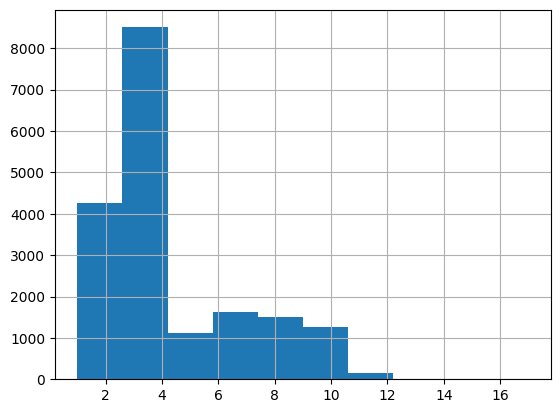

In [ ]:
a = []
for s in X_train:
  a.extend(s.split())
pd.DataFrame(a)[0].apply(len).hist()

In [ ]:
MAX_CHAR = 4 #So luong ki tu trong 1 tu

In [ ]:
def charEncoded(X):
  x = np.zeros((len(X), MAX_LEN, MAX_CHAR), dtype=np.int64) # +Pad

  for i,sentence in enumerate(X):
      sentence = sentence.replace("_", " ")
      sentence = sentence.split()
      for j,word in enumerate(sentence):
          if j > MAX_LEN-1:
              break
          for k,char in enumerate(word):
              if k > MAX_CHAR - 1:
                break
              try:
                  x[i,j,k] = char2idx[char]
              except:
                  print(char)
                  x[i,j,k] = char2idx["UNK"]

  return x


In [ ]:
X_train_char_encoded = charEncoded(X_train)
X_val_char_encoded = charEncoded(X_val)
X_test_char_encoded = charEncoded(X_test)


🥲
>
…
…
=
⭕
>
>
>
🤗
“
”
“
”
=
🥲


In [ ]:
X_train_char_encoded

array([[[ 86,   2,  89,  92],
        [ 78,   2,  87,  32],
        [ 82,  48,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[ 86,   2,  89,  92],
        [ 76,  82,   7,  68],
        [ 94,  65,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[ 87,   4,  68,   0],
        [ 77,  57,  88,  78],
        [ 76,  60,  88,  78],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       ...,

       [[ 86,  38,   2,   0],
        [ 75,  21,   0,   0],
        [110,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[ 79,   5,  88,   0],
        [ 89,  82,  17,  87],
        [ 91,  16,  92,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[ 88

In [ ]:
X_test[0]

'mỏng nhẹ , đáp_ứng nhiều nhu_cầu cần_thiết'

In [ ]:
list(map(lambda x: idx2char[x],X_test_char_encoded[0][3]))

['đ', 'á', 'p', 'PAD']

# MODEL

## CRF CLASS

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode


class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim)
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## WORD + CHARACTER + CONTEXTUAL EMBEDDING

In [ ]:
from transformers import AutoTokenizer,TFAutoModelForTokenClassification
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def ConcatToPretrainFormat(x, y, X_encoded, X_char_encoded, tokenizer, batch_size,is_shuffle = False):
  features = {k:[] for k in tokenizer.model_input_names}
  for i in range(len(x)):

    token = tokenizer(x[i],padding = 'max_length',max_length = MAX_LEN,truncation=True)
    for name in tokenizer.model_input_names:
      temp = np.asarray(token[name]).astype('float')
      features[name].append(temp)

  for k,v in features.items():
    features[k] = np.asarray(features[k])

  y_new = np.zeros((len(y),MAX_LEN)) # [CLS] token
  for i in range(len(y)):
      y_new[i] = AlignLabel().tokenize_and_alignlabel(x[i],y[i],tag2idx,tokenizer)

  y_new = [to_categorical(y_new[i],num_classes = len(tag2idx)) for i in range(len(y_new))]

  dataset = tf.data.Dataset.from_tensor_slices(
      (
      {"word_input":X_encoded,"char_input":X_char_encoded,
       "input_ids":features['input_ids'],"token_type_ids":features['token_type_ids'], "attention_mask":features['attention_mask']}
      ,y_new)
      )
  if is_shuffle:
    dataset = dataset.shuffle(buffer_size = len(y_new))
  dataset = dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return dataset


In [ ]:
train = ConcatToPretrainFormat(X_train,y_train,X_train_encoded, X_train_char_encoded, tokenizer,BATCH_SIZE,is_shuffle = True)
val = ConcatToPretrainFormat(X_val,y_val,X_val_encoded, X_val_char_encoded,tokenizer,BATCH_SIZE)
test = ConcatToPretrainFormat(X_test,y_test,X_test_encoded, X_test_char_encoded,tokenizer,BATCH_SIZE)
train

<_PrefetchDataset element_spec=({'word_input': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'char_input': TensorSpec(shape=(None, 256, 4), dtype=tf.int64, name=None), 'input_ids': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 256, 92), dtype=tf.float32, name=None))>

In [ ]:
# WORD EMBEDDING
input = Input(shape=(MAX_LEN,),name = 'word_input')
embedding = Embedding(input_dim= len(word2idx), output_dim=100,
                  input_length=MAX_LEN, embeddings_initializer = Constant(embedding_matrix),trainable = True, name = 'word_embedding')(input)

# CHAR EMBEDDING
char_input = Input(shape=(MAX_LEN, MAX_CHAR),name = 'char_input')
char = TimeDistributed(
    Embedding(input_dim=len(chars) + 2, output_dim = MAX_CHAR,
                input_length=MAX_CHAR,name = 'char_embedding'),name = 'time_char_embedding'
)(char_input)
char = TimeDistributed(
    Bidirectional(
        LSTM(MAX_CHAR, return_sequences=False,recurrent_dropout=0.1),
    )
)(char)

# CONTEXTUAL EMBEDDING
inputs_pretrained = {
    "input_ids" : Input(shape = (MAX_LEN),dtype = 'int32', name = 'input_ids'),
    "token_type_ids": Input(shape = (MAX_LEN),dtype = 'int32', name = 'token_type_ids'),
    "attention_mask": Input(shape = (MAX_LEN),dtype = 'int32', name = 'attention_mask')
}

pre_model = TFAutoModelForTokenClassification.from_pretrained(PRETRAINED_MODEL, output_hidden_states = True)
features = pre_model(inputs_pretrained)[-1]


All model checkpoint layers were used when initializing TFRobertaForTokenClassification.

Some layers of TFRobertaForTokenClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dropout = Dropout(0.1) (features[-1])

inputs = concatenate([embedding,char,dropout])

bi_lstm = Bidirectional(LSTM((768+100+8),return_sequences=True),merge_mode='sum') (inputs)

time = TimeDistributed(Dense(len(tag2idx),activation = 'relu')) (bi_lstm)

crf_layer = CRF(len(tag2idx))
output = crf_layer(time)

wcc_model = Model(inputs = [input,char_input,inputs_pretrained],outputs = output)
wcc_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 256, 4)]     0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                              

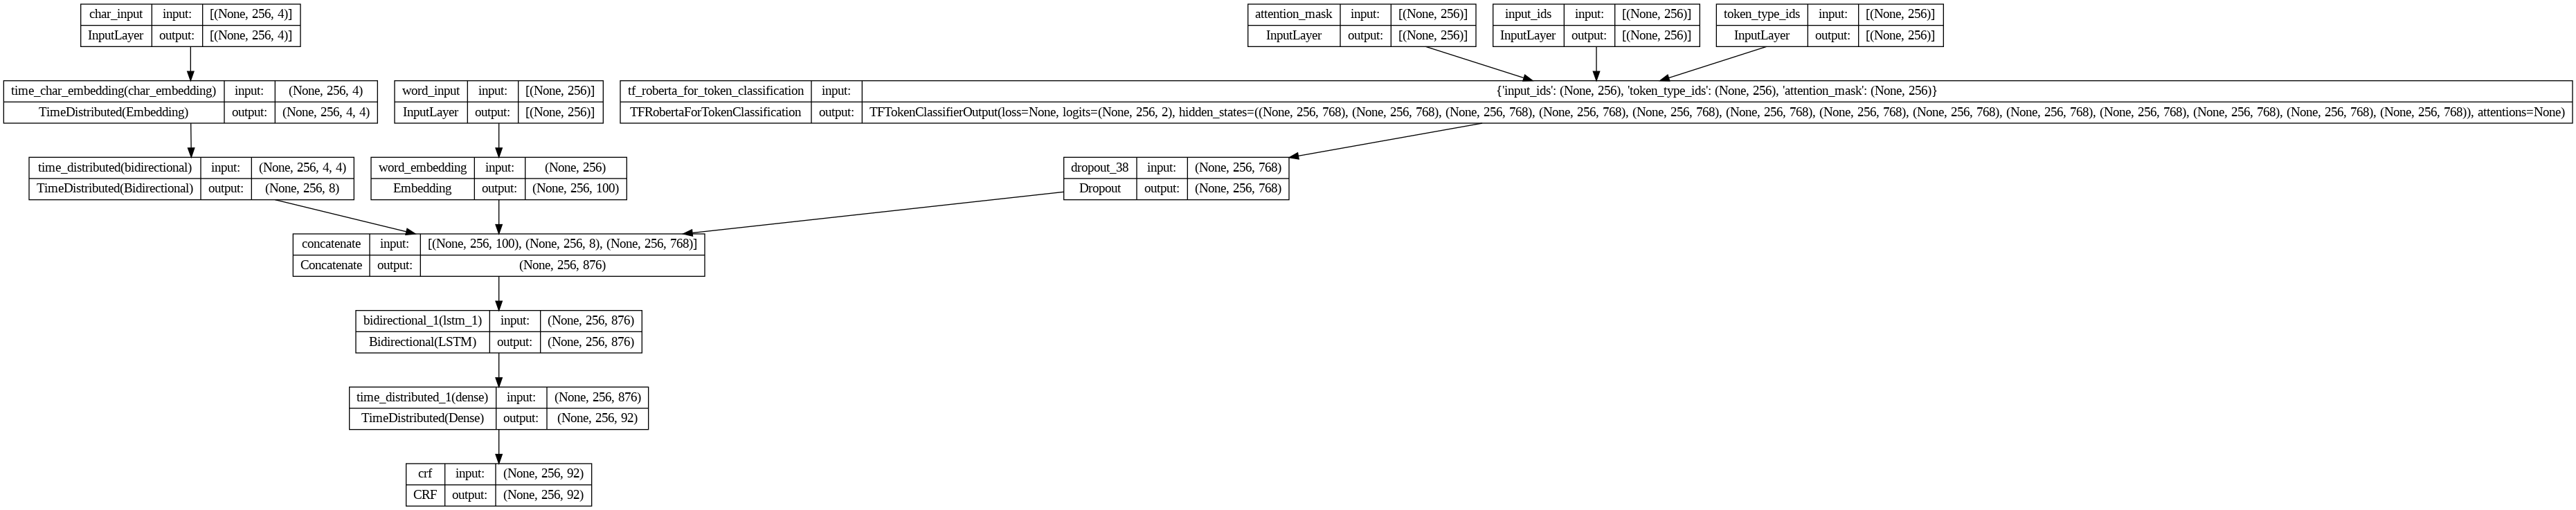

In [ ]:
tf.keras.utils.plot_model(wcc_model,show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor = 'viterbi_accuracy',
    patience = 4,
    restore_best_weights = True
    )


In [ ]:
wcc_model.compile(optimizer=tf.keras.optimizers.AdamW(5e-5),loss = crf_layer.loss,metrics = crf_layer.accuracy)

wcc_model.fit(
    train,
    validation_data = val,
    epochs = 30,
    verbose = 1,
    callbacks = early_stop
)

Epoch 1/30


134/134 [==============================] - 343s 2s/step - loss: 195.0700 - viterbi_accuracy: 0.8423 - val_loss: 885.0767 - val_viterbi_accuracy: 0.9563
Epoch 2/30
134/134 [==============================] - 246s 2s/step - loss: 47.9702 - viterbi_accuracy: 0.9564 - val_loss: 884.6483 - val_viterbi_accuracy: 0.9573
Epoch 3/30
134/134 [==============================] - 245s 2s/step - loss: 39.2997 - viterbi_accuracy: 0.9626 - val_loss: 882.4637 - val_viterbi_accuracy: 0.9651
Epoch 4/30
134/134 [==============================] - 251s 2s/step - loss: 31.1769 - viterbi_accuracy: 0.9705 - val_loss: 881.4779 - val_viterbi_accuracy: 0.9683
Epoch 5/30
134/134 [==============================] - 245s 2s/step - loss: 26.3053 - viterbi_accuracy: 0.9751 - val_loss: 881.5579 - val_viterbi_accuracy: 0.9673
Epoch 6/30
134/134 [==============================] - 250s 2s/step - loss: 22.6377 - viterbi_accuracy: 0.9784 - val_loss: 880.9111 - val_viterbi_accuracy: 0.9692
Epoch 7/30
134/134 [==================

# EVALUATE

In [ ]:
y_temp = []
for i in range(len(y_test)):
  y_t = AlignLabel().tokenize_and_alignlabel(X_test[i],y_test[i],tag2idx,tokenizer)
  y_temp.append(y_t)
y_temp = np.asarray(y_temp)[:,np.newaxis]
y_temp

array([[[31, 76, 91, ...,  0,  0,  0]],

       [[37, 82, 82, ...,  0,  0,  0]],

       [[ 1, 46, 46, ...,  0,  0,  0]],

       ...,

       [[ 6, 51, 51, ...,  0,  0,  0]],

       [[16, 61, 61, ...,  0,  0,  0]],

       [[37, 82,  0, ...,  0,  0,  0]]])

In [ ]:
def caculateAPMetrics(y_test,y_preds,print_report = False):
  f1_scores = []
  precision_scores = []
  recall_scores = []
  if print_report:
    y_test_flatten = []
    y_pred_flatten = []
  for i in range(len(y_test)):
    # yt = np.array(list(map(lambda x: tag2idx[x],y_test[i])))
    yt = pad_sequences([y_test[i][0]],maxlen=MAX_LEN,padding='post',truncating = 'post',value = tag2idx['PAD'])[0]
    y_pred = y_preds[i][0]
    yt = list(map(lambda x: idx2tag[x],yt))
    y_pred = list(map(lambda x: idx2tag[x],y_pred))

    # print(yt)
    # print(y_pred)
    # print("==========")
    if print_report:
      # dont get B-, I-
      y_test_flatten.extend(list(map(lambda x:x[2:] if "#" in x else x,yt)))
      y_pred_flatten.extend(list(map(lambda x:x[2:] if "#" in x else x,y_pred)))

    f1_scores.append(f1_score(yt,y_pred,average = 'macro',zero_division=0))
    precision_scores.append(precision_score(yt,y_pred,average = 'macro',zero_division=0))
    recall_scores.append(recall_score(yt,y_pred,average = 'macro',zero_division=0))

  if print_report:
    print(classification_report(y_test_flatten, y_pred_flatten,zero_division=0))
  return np.mean(precision_scores),np.mean(recall_scores),np.mean(f1_scores)

## WORD + CHARACTER + CONTEXTUAL

In [ ]:
y_preds_wcc = np.argmax(wcc_model.predict(test),axis=-1)

45/45 [==============================] - 17s 226ms/step


In [ ]:
y_preds_wcc[3]

array([91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
       91, 91, 91, 91, 91, 91, 91, 91, 91, 91,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

### ASPECT#POLARITY

In [ ]:
wcc_pre,wcc_re,wcc_f1 = caculateAPMetrics(y_temp,y_preds_wcc[:,np.newaxis],0)
print("Precision score:",wcc_pre)
print("Recall score:",wcc_re)
print("F1 score:",wcc_f1)

Precision score: 0.6264840182088627
Recall score: 0.636809101825688
F1 score: 0.6180187626835315
